# **Preprocess Data and Create Labels and Features**


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [3]:
DATA_PATH = os.path.join('dataset_hand_gestures')

actions = np.array(["Start_End", "Maju", "Mundur", "Kanan", "Kiri", "Atas", "Bawah", "Putar_kanan", "Putar_kiri"])

sequence_length = 25

In [4]:
label_map = {label: num for num, label in enumerate(actions)}

sequences, labels = [], []
for action in actions:
    # Filter directories by removing 'sequence_' prefix and converting to int
    for sequence in sorted([int(seq.replace("sequence_", "")) for seq in os.listdir(os.path.join(DATA_PATH, action))]):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, f"sequence_{sequence}", f"frame_{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape

(135, 25, 63)

In [5]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(94, 25, 63)
(41, 25, 63)
(94, 9)
(41, 9)


# **Build and Train LSTM Neural Network**


In [6]:
checkpoint = ModelCheckpoint('hand_ges_2.keras', monitor='categorical_accuracy', verbose=1,
                             mode='max', save_best_only=True, save_weights_only=False, save_freq='epoch')

In [7]:
model = Sequential()

model.add(TimeDistributed(
    Dense(units=128, activation='tanh'), input_shape=(25, 63)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 25, 128)           8192      
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 25, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 25, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 25, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                       


Epoch 1/150


3/3 [==============================] - ETA: 0s - loss: 2.2282 - categorical_accuracy: 0.1383
Epoch 1: categorical_accuracy improved from -inf to 0.13830, saving model to hand_ges_2.keras
3/3 [==============================] - 13s 1s/step - loss: 2.2282 - categorical_accuracy: 0.1383 - val_loss: 2.2221 - val_categorical_accuracy: 0.0976
Epoch 2/150
3/3 [==============================] - ETA: 0s - loss: 2.1897 - categorical_accuracy: 0.1489
Epoch 2: categorical_accuracy improved from 0.13830 to 0.14894, saving model to hand_ges_2.keras
3/3 [==============================] - 0s 171ms/step - loss: 2.1897 - categorical_accuracy: 0.1489 - val_loss: 2.2588 - val_categorical_accuracy: 0.0976
Epoch 3/150
3/3 [==============================] - ETA: 0s - loss: 2.2038 - categorical_accuracy: 0.1489
Epoch 3: categorical_accuracy did not improve from 0.14894
3/3 [==============================] - 0s 107ms/step - loss: 2.2038 - categorical_accuracy: 0.1489 - val_loss: 2.2515 - val_cate

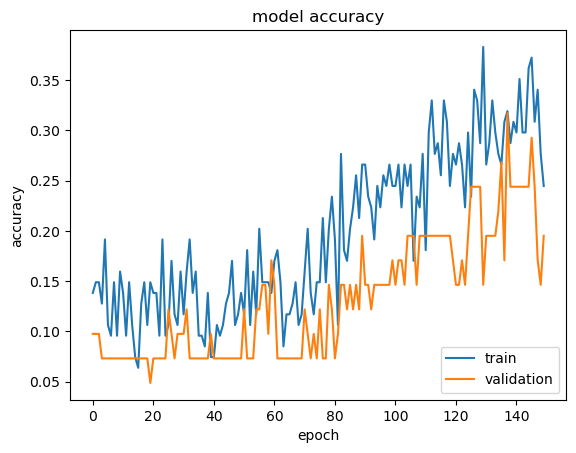

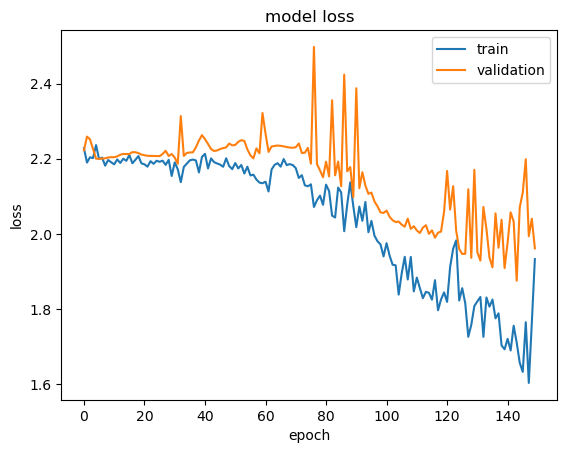

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 25, 128)           8192      
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 25, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 25, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 25, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                        

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
train_model = model.fit(X_train, y_train, epochs=150, callbacks=[
                        checkpoint], validation_data=(X_test, y_test))

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

model.summary()

In [624]:
# plot_model(model, to_file="model1.png", show_shapes=True)

# **Save Weights**


In [8]:
number_of_classes = len(actions)
current_date = '10042024'  # changes manually
version = 1

model_filename = "model/model_" + \
    str(number_of_classes) + '_' + 'lstm' + '_' + \
    current_date + '_' + str(version) + ".h5"

print(model_filename)

model.save(model_filename)
model.load_weights(model_filename)

model/model_5_lstm_10042024_1.h5


# **Evaluation using Confusion Matrix and Accuracy**


In [10]:
yhat = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [11]:
print(actions[np.argmax(yhat[2])])
print(actions[np.argmax(y_test[2])])

Stop
Stop


In [12]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [13]:
from sklearn.metrics import classification_report

report = classification_report(ytrue, yhat, target_names=actions)
print(report)

              precision    recall  f1-score   support

        Stop       1.00      1.00      1.00        15
        Maju       1.00      1.00      1.00        20
      Mundur       1.00      1.00      1.00         9
       Kanan       1.00      1.00      1.00        15
        Kiri       1.00      1.00      1.00        16

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



In [14]:
# mcm = multilabel_confusion_matrix(ytrue, yhat)
# print(mcm)

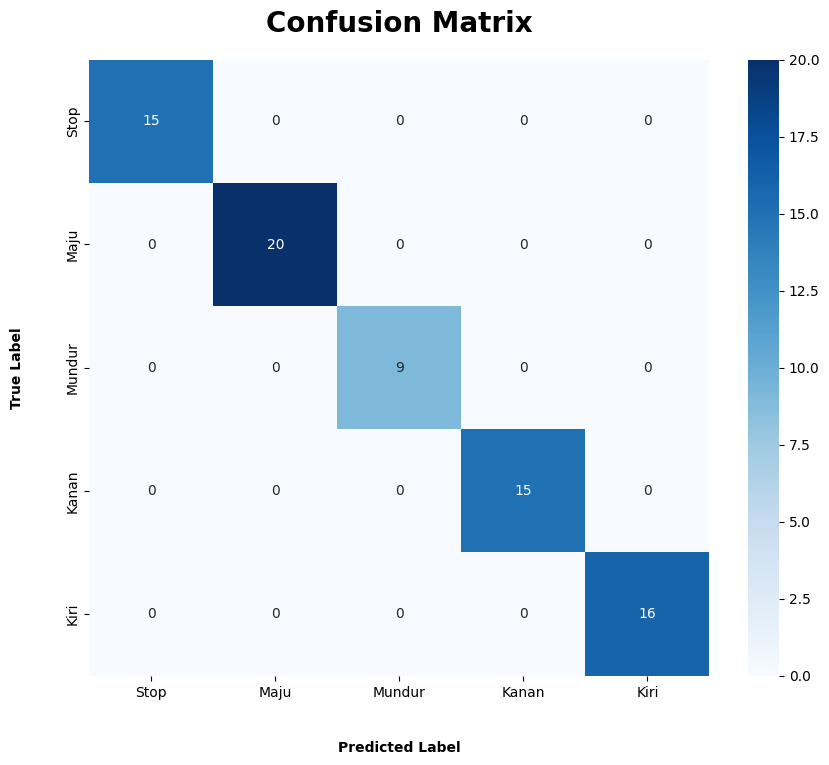

In [15]:
ytrue = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(10, 8))
heatMap = sns.heatmap(conf_matrix, annot=True, fmt='d',
                      cmap='Blues', xticklabels=actions, yticklabels=actions)

heatMap.set_xlabel('Predicted Label', labelpad=30, weight='bold')
heatMap.set_ylabel('True Label', labelpad=30, weight='bold')

heatMap.set_title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.show()

In [16]:
from sklearn.metrics import precision_recall_fscore_support

metrics = precision_recall_fscore_support(ytrue, yhat)

precision_per_class = metrics[0]
recall_per_class = metrics[1]
f1_score_per_class = metrics[2]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

accuracy_per_class = [(conf_matrix[i, i] / np.sum(conf_matrix[:, i]))
                      for i in range(len(actions))]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[i]}\n")

Class: Stop
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Maju
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Mundur
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Kanan
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Kiri
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: Stop
Accuracy: 1.0

Class: Maju
Accuracy: 1.0

Class: Mundur
Accuracy: 1.0

Class: Kanan
Accuracy: 1.0

Class: Kiri
Accuracy: 1.0

